In [2]:
!pip show kaggle


Name: kaggle
Version: 1.7.4.5
Summary: Access Kaggle resources anywhere
Home-page: 
Author: 
Author-email: Kaggle <support@kaggle.com>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by contract or
      otherw

In [3]:
!pip install kaggle --upgrade --quiet



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
print(os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")))


True


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = r"C:\Users\ASUS\.kaggle"


In [6]:
!kaggle datasets list -s plant


ref                                                   title                                        size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  -------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
vipoooool/new-plant-diseases-dataset                  New Plant Diseases Dataset             2897709187  2018-11-18 07:09:16.050000         150756       1461  0.75             
abdallahalidev/plantvillage-dataset                   PlantVillage Dataset                   4371949460  2019-09-01 11:52:26.883000          75826        735  0.875            
vbookshelf/v2-plant-seedlings-dataset                 V2 Plant Seedlings Dataset             3427338216  2018-12-13 14:20:52.903000          13109        302  0.75             
rashikrahmanpritom/plant-disease-recognition-dataset  Plant disease recognition dataset      1339624018  2021-07-04

In [7]:
!kaggle datasets download -d emmarex/plantdisease -p ./data


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown




  0%|          | 0.00/658M [00:00<?, ?B/s]
  9%|8         | 59.0M/658M [00:00<00:01, 612MB/s]
 18%|#7        | 118M/658M [00:00<00:00, 591MB/s] 
 27%|##6       | 177M/658M [00:00<00:00, 600MB/s]
 36%|###5      | 235M/658M [00:00<00:00, 573MB/s]
 44%|####4     | 290M/658M [00:00<00:00, 466MB/s]
 51%|#####1    | 337M/658M [00:00<00:00, 379MB/s]
 59%|#####9    | 389M/658M [00:00<00:00, 419MB/s]
 66%|######5   | 433M/658M [00:01<00:00, 391MB/s]
 72%|#######1  | 473M/658M [00:01<00:00, 373MB/s]
 78%|#######8  | 516M/658M [00:01<00:00, 391MB/s]
 85%|########4 | 558M/658M [00:01<00:00, 403MB/s]
 91%|######### | 598M/658M [00:01<00:00, 370MB/s]
 99%|#########9| 653M/658M [00:01<00:00, 424MB/s]
100%|##########| 658M/658M [00:01<00:00, 433MB/s]


In [ ]:
import os

# list first 10 folders inside dataset
os.listdir("./data/plantvillage/PlantVillage")[:10]


In [16]:
!pip install kaggle tensorflow matplotlib numpy

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Example dataset: PlantVillage
!kaggle datasets download -d emmarex/plantdisease

# Unzip dataset
with zipfile.ZipFile("plantdisease.zip", "r") as zip_ref:
    zip_ref.extractall("./data")


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


NameError: name 'zipfile' is not defined

In [ ]:
data_dir = "./data/PlantVillage"
IMG_SIZE = 224
BATCH_SIZE = 32

class_names = sorted(os.listdir(data_dir))
print("Number of classes:", len(class_names))
print("Class names sample:", class_names[:10])


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


In [ ]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # freeze pretrained layers

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augment(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


In [24]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1467s 1s/step - accuracy: 0.4731 - loss: 1.6140 - val_accuracy: 0.4979 - val_loss: 1.1067
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1406s 1s/step - accuracy: 0.4877 - loss: 1.1466 - val_accuracy: 0.4876 - val_loss: 1.0525
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1426s 1s/step - accuracy: 0.4927 - loss: 1.0885 - val_accuracy: 0.4893 - val_loss: 1.0321
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 21676s 21s/step - accuracy: 0.4891 - loss: 1.0652 - val_accuracy: 0.4858 - val_loss: 1.0229
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 735s 712ms/step - accuracy: 0.4924 - loss: 1.0425 - val_accuracy: 0.4850 - val_loss: 1.0128
Epoch 6/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 725s 702ms/step - accuracy: 0.4989 - loss: 1.0245 - val_accuracy: 0.4832 - val_loss: 1.0067
Epoch 7/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 711s 689ms/step - accuracy: 0.4888 - loss: 1.0193 - val_accuracy: 0.4784 - val_loss: 1.0004
Epoch 8/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 714s 692ms/step - accuracy

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")


In [ ]:
model.save("plant_disease_model.keras")
print("✅ Model saved as plant_disease_model.keras")


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")
    
    # Show the image
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.show()



predict_image("./data/PlantVillage/Tomato___Late_blight/0a0e4b4e-123.jpg")


Sample image path: ./data/PlantVillage\Pepper__bell___Bacterial_spot\0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicted: Tomato_Late_blight (9.50% confidence)


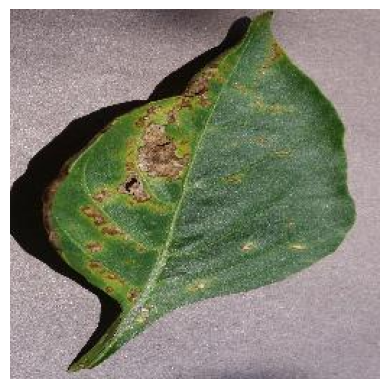

In [29]:
import glob

# Grab a random image from any class folder
sample_image = glob.glob("./data/PlantVillage/*/*")[0]
print("Sample image path:", sample_image)

# Run prediction on that real image
predict_image(sample_image)


In [ ]:
import os

print("Contents of ./data:", os.listdir("./data"))


In [ ]:
print("Contents of ./data/PlantVillage:", os.listdir("./data/PlantVillage")[:10])


Sample image path: ./data/PlantVillage\Pepper__bell___Bacterial_spot\0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted: Tomato_Late_blight (9.50% confidence)


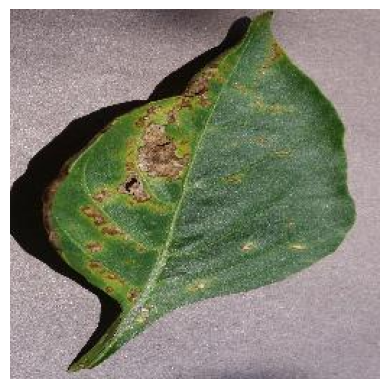

In [33]:
import glob

# Grab any random image from the dataset
sample_image = glob.glob("./data/PlantVillage/*/*")[0]
print("Sample image path:", sample_image)

predict_image(sample_image)


In [35]:
!pip install opencv-python
import cv2



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB 56.9 kB/s eta 0:11:26
   ---------------------------------------- 0.0/39.0 MB 56.9 kB/s eta 0:11:26
   ---------------------------------------- 0.0/39.0 MB 56.9 kB/s eta 0:11:26
   ---------------------------------------- 0.0/39.0 MB 56.9 kB/s eta 0:11:26
   ---------------------------------------- 0.0/39.0 MB 56.9 kB/s eta 0:11:26
   ---------------------------------------- 0.0/39

Testing image: ./data/PlantVillage\Potato___Late_blight\f4e6847d-d381-4849-9ff1-930cfb597d08___RS_LB 5097.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted: Tomato_Late_blight (9.50% confidence)


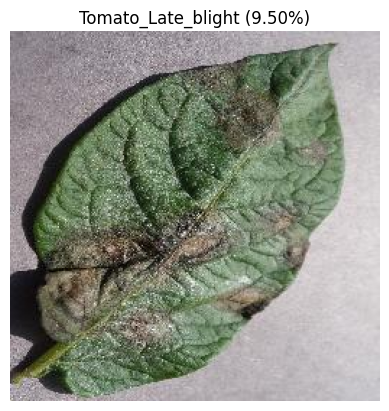

In [36]:
import random

# Pick a random image path
import glob
sample_image = random.choice(glob.glob("./data/PlantVillage/*/*"))
print("Testing image:", sample_image)

# Load using OpenCV
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB

# Resize to match model input size
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

# Prepare for prediction
img_array = np.expand_dims(img_resized, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)

print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")

# Show image
plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()



Testing: ./data/PlantVillage\Tomato_healthy\9fb8872e-e963-4d2c-9b16-62757705ca3f___RS_HL 0130.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


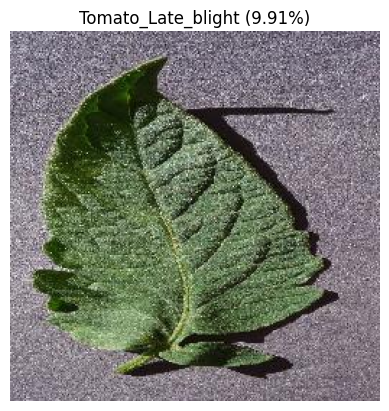


Testing: ./data/PlantVillage\Tomato_Leaf_Mold\19014458-f5de-4c92-beb5-8faf0e6a6bf3___Crnl_L.Mold 8754.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


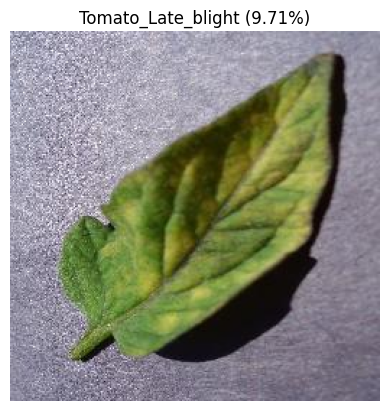


Testing: ./data/PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\5f30574a-e6e1-416b-aa31-4990f4a27748___YLCV_NREC 2046.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


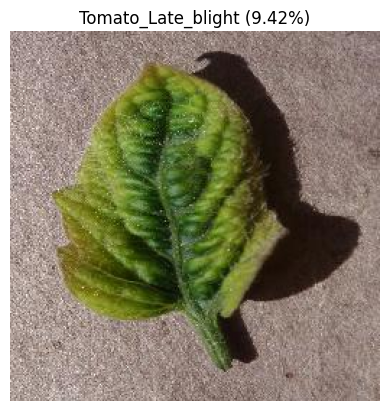


Testing: ./data/PlantVillage\Tomato_Early_blight\2792287f-aa8e-4c03-aabe-479e75cdc0f8___RS_Erly.B 9584.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


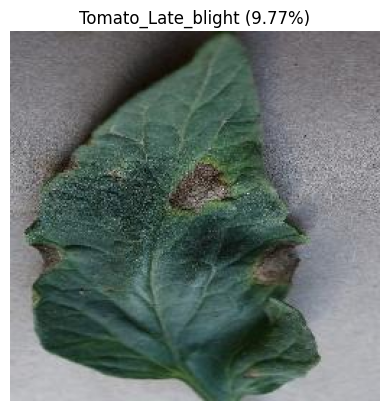


Testing: ./data/PlantVillage\Tomato_healthy\96a7aed7-5548-4977-92a9-10cc2282e84a___RS_HL 0204.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


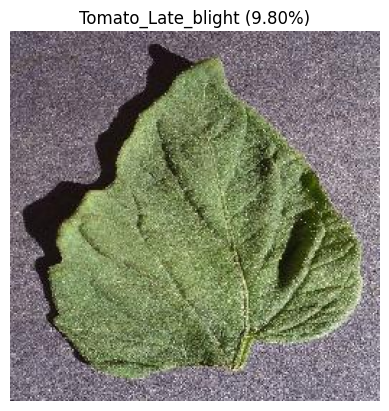

In [37]:
for i in range(5):  # test 5 random samples
    sample_image = random.choice(glob.glob("./data/PlantVillage/*/*"))
    print("\nTesting:", sample_image)

    img = cv2.imread(sample_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib


data_dir = pathlib.Path("./data/PlantVillage")  # change path if needed
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


data_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # freeze base layers

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augment(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 
)


model.save("plant_disease_model.keras")
print("✅ Model saved as plant_disease_model.keras")


Found 41276 files belonging to 16 classes.
Using 33021 files for training.
Found 41276 files belonging to 16 classes.
Using 8255 files for validation.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 733s 701ms/step - accuracy: 0.4540 - loss: 1.6781 - val_accuracy: 0.4965 - val_loss: 1.1323
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 747s 724ms/step - accuracy: 0.4920 - loss: 1.1669 - val_accuracy: 0.4929 - val_loss: 1.0824
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 723s 701ms/step - accuracy: 0.4936 - loss: 1.0997 - val_accuracy: 0.4871 - val_loss: 1.0637
Epoch 4/10
103

In [9]:
import os
print(os.listdir())


['.android', '.bash_history', '.cache', '.degit', '.docker', '.eclipse', '.gitconfig', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.kaggle', '.keras', '.lesshst', '.matplotlib', '.node_repl_history', '.npmrc', '.p2', '.redhat', '.ssh', '.vscode', '.yarnrc', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'data', 'Documents', 'Downloads', 'eclipse', 'eclipse-workspace', 'enter', 'enter.pub', 'Favorites', 'Links', 'Local Settings', 'Manshi', 'manshiiv', 'Music', 'My Documents', 'NetHood', 'nodejs', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TM.blf', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'plantdisease.zip', 'plant_disease_diagnosis.ipynb', 'plant_disease_model.keras', 'Postman', 'PrintHood', 'PycharmProjects', 'Recent', 'S

In [11]:
from tensorflow.keras.models import load_model
model = load_model("plant_disease_model.keras")


In [12]:
loss, acc = model.evaluate(val_ds)
print(f"Validation accuracy: {acc:.2f}")


258/258 ━━━━━━━━━━━━━━━━━━━━ 255s 972ms/step - accuracy: 0.4789 - loss: 1.0124
Validation accuracy: 0.48


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 224  # same size you used during training
CLASS_NAMES =  ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy','healthy']  # update with your dataset classes

def predict_image(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # normalize

    # Predict
    prediction = model.predict(img_array)
    class_idx = prediction.argmax()
    class_name = CLASS_NAMES[class_idx]

    # Show result
    plt.imshow(img)
    plt.title(f"Prediction: {class_name}")
    plt.axis("off")
    plt.show()

    print("✅ Predicted class:", class_name)


In [44]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/PlantVillage",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32
)

# Extract class names automatically
CLASS_NAMES = train_ds.class_names
print("Class names:", CLASS_NAMES)


Found 41276 files belonging to 16 classes.
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


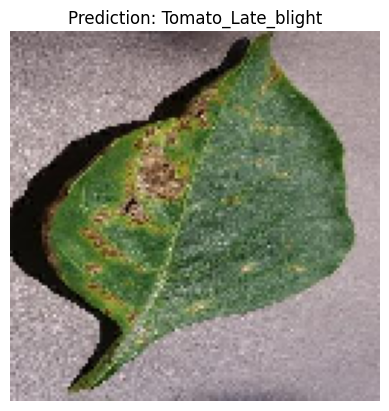

✅ Predicted class: Tomato_Late_blight


In [30]:
sample_image = glob.glob("./data/PlantVillage/*/*")[0]
predict_image(sample_image)


In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224 # same size as training

def predict_leaf(image_path):
    # Read image with OpenCV
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not read the image. Check the file path.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = img_resized / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    class_idx = prediction.argmax()
    class_name = CLASS_NAMES[class_idx]

    # Show image + result
    plt.imshow(img)
    plt.title(f"Prediction: {class_name}")
    plt.axis("off")
    plt.show()

    print("✅ Predicted class:", class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


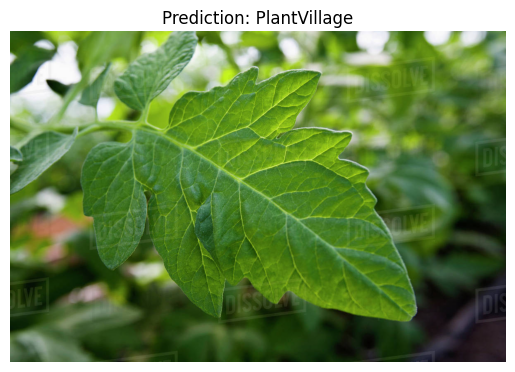

✅ Predicted class: PlantVillage


In [46]:
predict_leaf(r"C:\Users\ASUS\OneDrive\Desktop\leaf.jpg")


In [47]:

CLASS_NAMES = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]


In [48]:
def predict_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    prediction = model.predict(img_array)
    class_idx = prediction.argmax()
    class_name = CLASS_NAMES[class_idx]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

    print("✅ Predicted class:", class_name)


In [38]:
model.save("plant_disease_model_fixed.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


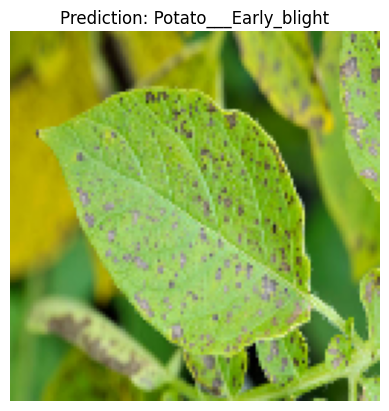

✅ Predicted class: Potato___Early_blight


In [39]:
predict_leaf(r"C:\Users\ASUS\OneDrive\Desktop\test2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


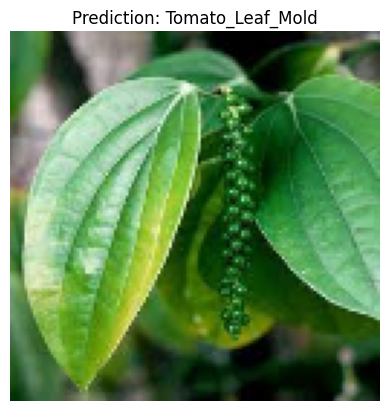

✅ Predicted class: Tomato_Leaf_Mold


In [40]:
predict_leaf(r"C:\Users\ASUS\OneDrive\Desktop\test2.jpeg")

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

IMG_SIZE = (224, 224)   # same as training

def preprocess_image(img_path):
    # Load and resize
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    
    # Normalize
    img_array = img_array / 255.0  
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_leaf(img_path):
    # Preprocess
    img_array = preprocess_image(img_path)
    
    # Predict
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_name = class_names[class_index]
    
    # Show result
    print(f"✅ Predicted class: {class_name}")
    
    # Display image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
✅ Predicted class: PlantVillage


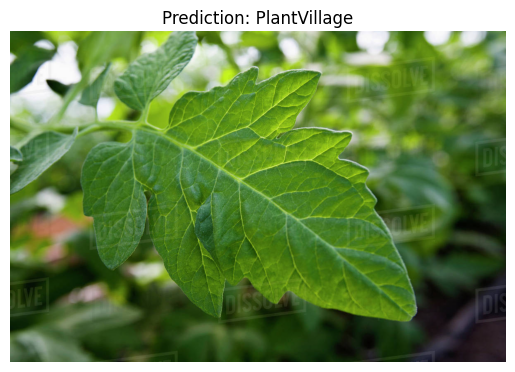

In [53]:
predict_leaf(r"C:\Users\ASUS\OneDrive\Desktop\leaf.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
✅ Predicted class: PlantVillage


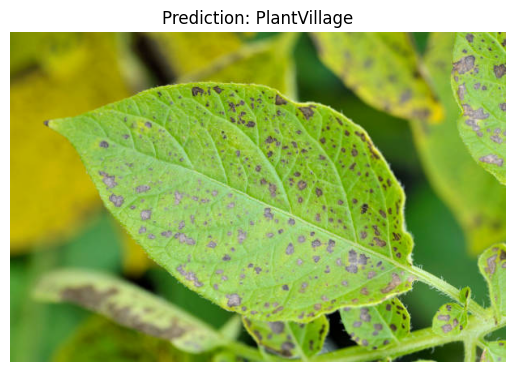

In [54]:
predict_leaf(r"C:\Users\ASUS\OneDrive\Desktop\test2.jpg")

In [55]:
import os

data_dir = "./data/PlantVillage"  # your dataset path
CLASS_NAMES = sorted([
    d for d in os.listdir(data_dir) 
    if os.path.isdir(os.path.join(data_dir, d))
])

print("Class names:", CLASS_NAMES)


Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [56]:
CLASS_NAMES.pop(2)


'PlantVillage'

In [59]:
import tensorflow as tf
import os

# Path to dataset
data_dir = "./data/PlantVillage"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset properly
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get correct class names
CLASS_NAMES = train_ds.class_names
print("Class names:", CLASS_NAMES)


Found 41276 files belonging to 16 classes.
Using 33021 files for training.
Found 41276 files belonging to 16 classes.
Using 8255 files for validation.
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [60]:
import os

data_dir = "./data/PlantVillage"
print("Subfolders (classes) in dataset:", os.listdir(data_dir))


Subfolders (classes) in dataset: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [61]:
import os, shutil

base_dir = "./data/PlantVillage"

# check if there's a nested "PlantVillage" folder
nested_dir = os.path.join(base_dir, "PlantVillage")

if os.path.exists(nested_dir):
    for folder in os.listdir(nested_dir):
        src = os.path.join(nested_dir, folder)
        dst = os.path.join(base_dir, folder)
        if os.path.isdir(src):
            print(f"Moving {src} -> {dst}")
            shutil.move(src, dst)

    # remove the empty inner folder
    shutil.rmtree(nested_dir)
    print("✅ Fixed: removed nested PlantVillage folder.")
else:
    print("No nested folder found. Your dataset is fine!")


Moving ./data/PlantVillage\PlantVillage\Pepper__bell___Bacterial_spot -> ./data/PlantVillage\Pepper__bell___Bacterial_spot
Moving ./data/PlantVillage\PlantVillage\Pepper__bell___healthy -> ./data/PlantVillage\Pepper__bell___healthy
Moving ./data/PlantVillage\PlantVillage\Potato___Early_blight -> ./data/PlantVillage\Potato___Early_blight
Moving ./data/PlantVillage\PlantVillage\Potato___healthy -> ./data/PlantVillage\Potato___healthy
Moving ./data/PlantVillage\PlantVillage\Potato___Late_blight -> ./data/PlantVillage\Potato___Late_blight
Moving ./data/PlantVillage\PlantVillage\Tomato_Bacterial_spot -> ./data/PlantVillage\Tomato_Bacterial_spot
Moving ./data/PlantVillage\PlantVillage\Tomato_Early_blight -> ./data/PlantVillage\Tomato_Early_blight
Moving ./data/PlantVillage\PlantVillage\Tomato_healthy -> ./data/PlantVillage\Tomato_healthy
Moving ./data/PlantVillage\PlantVillage\Tomato_Late_blight -> ./data/PlantVillage\Tomato_Late_blight
Moving ./data/PlantVillage\PlantVillage\Tomato_Leaf_Mol

In [62]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

print("Class names:", train_ds.class_names)


Found 41276 files belonging to 15 classes.
Using 33021 files for training.
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [63]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
base_dir = "./data/PlantVillage"

# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
CLASS_NAMES = train_ds.class_names
print("✅ Classes:", CLASS_NAMES)

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Save
model.save("plant_disease_model.keras")
print("✅ Model saved as plant_disease_model.keras")


Found 41276 files belonging to 15 classes.
Using 33021 files for training.
Found 41276 files belonging to 15 classes.
Using 8255 files for validation.
✅ Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1304s 1s/step - accuracy: 0.5661 - loss: 1.4746 - val_accuracy: 0.8638 - val_loss: 0.4718
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1203s 1s/step - accuracy: 0.8645 - loss: 0.4661 - val_accuracy: 0.8992 - val_loss: 0.3411
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1225s 1s/step - accuracy: 0.8918 - loss: 0.3579 - val_accuracy: 0.9141 - val_loss: 0.2881
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    class_weight=class_weight)


Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 799s 765ms/step - accuracy: 0.2500 - loss: 2.8830 - val_accuracy: 0.6517 - val_loss: 1.1552
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 724s 701ms/step - accuracy: 0.6384 - loss: 1.2270 - val_accuracy: 0.7584 - val_loss: 0.8214
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 709s 687ms/step - accuracy: 0.7160 - loss: 0.9267 - val_accuracy: 0.7978 - val_loss: 0.6881
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 703s 681ms/step - accuracy: 0.7593 - loss: 0.7741 - val_accuracy: 0.8206 - val_loss: 0.6066
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 703s 681ms/step - accuracy: 0.7834 - loss: 0.7064 - val_accuracy: 0.8339 - val_loss: 0.5581
Epoch 6/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 704s 682ms/step - accuracy: 0.7942 - loss: 0.6557 - val_accuracy: 0.8437 - val_loss: 0.5198
Epoch 7/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 706s 684ms/step - accuracy: 0.8088 - loss: 0.6115 - val_accuracy: 0.8505 - val_loss: 0.4987
Epoch 8/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 708s 686ms/step - ac

In [ ]:
model_path = os.path.abspath("models/plant_disease_model.keras")
